# Predict the German Election - Machine Learning Final Model FDP

In [1]:
"""Load libraries"""

# libraries for time-series utilities
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# libraries for data transformation, visualization and modeling
import pandas_gbq as gbq
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import os
import sys

#libraries for machine learning
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from mlens.ensemble import SuperLearner
from xgboost import XGBRegressor

#libraries for metrics
from sklearn.metrics import mean_squared_error
from math import sqrt


[MLENS] backend: threading


In [2]:
"""Set-up data"""

#set working directory 
path = "/Users/dangngochuy/Desktop/Hertie/Hertie 3rd semester/Machine Learning/Predicting-German-Election/Code/Transformed Data"
os.chdir(path)

#load data
fdp = pd.read_csv("combined_data_fdp.csv", index_col='date', parse_dates=True)
fdp.head()

,support
date,
2013-10-23,3.656463
2013-10-24,3.665986
2013-10-25,3.675510
2013-10-26,3.664521
2013-10-27,3.653532


## Feature Engineering for Machine Learning Model

In [3]:
"""Create utilities for time-series modeling."""

def _keep(window, windows):
  """Helper function for creating rolling windows."""
  windows.append(window.copy())
  return -1.  # Float return value required for Pandas apply.


def create_rolling_features_label(series, window_size, pred_offset, pred_n=1):
  """Computes rolling window of the series and creates rolling window of label."""
  if series.isnull().sum() > 0:
    raise ValueError('Series must not contain missing values.')
  if pred_n < 1:
    raise ValueError('pred_n must not be < 1.')
  if len(series) < (window_size + pred_offset + pred_n):
    raise ValueError('window_size + pred_offset + pred_n must not be greater '
                     'than series length.')
  total_steps = len(series)

  def compute_rolling_window(series, window_size):
    # Accumulate series into list.
    windows = []
    series.rolling(window_size)\
      .apply(_keep, args=(windows,))
    return np.array(windows)

  features_start = 0
  features_end = total_steps - (pred_offset - 1) - pred_n
  historical_windows = compute_rolling_window(
      series[features_start:features_end], window_size)
  # Get label pred_offset steps into the future.
  label_start, label_end = window_size + pred_offset - 1, total_steps
  label_series = series[label_start:label_end]
  y = compute_rolling_window(label_series, pred_n)
  if pred_n == 1:
    columns = ['label']
  else:
    columns = ['label_{}_steps'.format(i) for i in range(pred_n)]
  # Make dataframe. Combine features and labels.
  label_ix = label_series.index[0:len(label_series) + 1 - pred_n]
  df = pd.DataFrame(y, columns=columns, index=label_ix)
  df.index.name = 'pred_date'
  # Populate dataframe with past sales.
  for day in range(window_size - 1, -1, -1):
    day_rel_label = pred_offset + window_size - day - 1
    df.insert(0, '-{}_steps'.format(day_rel_label), historical_windows[:, day])
  return df


def add_aggregate_features(df, time_series_col_names):
  """Compute summary statistic features for every row of dataframe."""
  x = df[time_series_col_names]
  features = {}
  features['mean'] = x.mean(axis=1)
  features['std'] = x.std(axis=1)
  features['min'] = x.min(axis=1)
  features['max'] = x.max(axis=1)
  percentiles = range(10, 100, 20)
  for p in percentiles:
    features['{}_per'.format(p)] = np.percentile(x, p, axis=1)
  df_features = pd.DataFrame(features, index=x.index)
  return df_features.merge(df, left_index=True, right_index=True)


def move_column_to_end(df, column_name):
  temp = df[column_name]
  df.drop(column_name, axis=1, inplace=True)
  df[column_name] = temp


def is_between_dates(dates, start=None, end=None):
  """Return boolean indices indicating if dates occurs between start and end."""
  if start is None:
    start = pd.to_datetime(0)
  if end is None:
    end = pd.to_datetime(sys.maxsize)
  date_series = pd.Series(pd.to_datetime(dates))
  return date_series.between(start, end).values


def _count_holidays(dates, months, weeks):
  """Count number of holidays spanned in prediction windows."""
  cal = calendar()
  holidays = cal.holidays(start=dates.min(), end=dates.max())

  def count_holidays_during_month(date):
    n_holidays = 0
    beg = date
    end = date + pd.DateOffset(months=months, weeks=weeks)
    for h in holidays:
      if beg <= h < end:
        n_holidays += 1
    return n_holidays

  return pd.Series(dates).apply(count_holidays_during_month)


def _get_day_of_month(x):
  """From a datetime object, extract day of month."""
  return int(x.strftime('%d'))


def add_date_features(df, dates, months, weeks, inplace=False):
  """Create features using date that is being predicted on."""
  if not inplace:
    df = df.copy()
  df['doy'] = dates.dayofyear
  df['dom'] = dates.map(_get_day_of_month)
  df['month'] = dates.month
  df['year'] = dates.year
  df['n_holidays'] = _count_holidays(dates, months, weeks).values
  return df


class Metrics(object):
  """Performance metrics for regressor."""

  def __init__(self, y_true, predictions):
    self.y_true = y_true
    self.predictions = predictions
    self.residuals = self.y_true - self.predictions
    self.rmse = self.calculate_rmse(self.residuals)
    self.mae = self.calculate_mae(self.residuals)
    self.malr = self.calculate_malr(self.y_true, self.predictions)

  def calculate_rmse(self, residuals):
    """Root mean squared error."""
    return np.sqrt(np.mean(np.square(residuals)))

  def calculate_mae(self, residuals):
    """Mean absolute error."""
    return np.mean(np.abs(residuals))

  def calculate_malr(self, y_true, predictions):
    """Mean absolute log ratio."""
    return np.mean(np.abs(np.log(1 + predictions) - np.log(1 + y_true)))

  def report(self, name=None):
    if name is not None:
      print_string = '{} results'.format(name)
      print(print_string)
      print('~' * len(print_string))
    print('RMSE: {:2.3f}\nMAE: {:2.3f}\nMALR: {:2.3f}'.format(
        self.rmse, self.mae, self.malr))

In [4]:
"""Create parameters for rolling window features"""

WINDOW_SIZE = 30  # Timesteps to be used as features in modeling, can be a hyperparameter for tuning
HORIZON = 3 # Predict approximately 3 days into the future
LABELS_SIZE = 1  # The label will be the voteshare of 1 day


In [5]:
"""Create rolling window dataframe with 30 timesteps for each parties"""

fdp_series = pd.Series(fdp['support'], index=fdp.index)
fdp_df = create_rolling_features_label(fdp_series, window_size=WINDOW_SIZE, pred_offset=HORIZON)
fdp_df.tail()

/Users/dangngochuy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


,-32_steps,-31_steps,-30_steps,-29_steps,-28_steps,-27_steps,-26_steps,-25_steps,-24_steps,-23_steps,...,-11_steps,-10_steps,-9_steps,-8_steps,-7_steps,-6_steps,-5_steps,-4_steps,-3_steps,label
pred_date,,,,,,,,,,,,,,,,,,,,,
2017-09-17,8.664626,8.694929,8.725232,8.755535,8.806246,8.856957,8.907669,8.933890,8.960111,8.956401,...,8.962894,9.062009,9.134223,9.147253,9.180691,9.214129,9.237363,9.260597,9.336211,9.471219
2017-09-18,8.694929,8.725232,8.755535,8.806246,8.856957,8.907669,8.933890,8.960111,8.956401,8.962894,...,9.062009,9.134223,9.147253,9.180691,9.214129,9.237363,9.260597,9.336211,9.401622,9.495814
2017-09-19,8.725232,8.755535,8.806246,8.856957,8.907669,8.933890,8.960111,8.956401,8.962894,8.928571,...,9.134223,9.147253,9.180691,9.214129,9.237363,9.260597,9.336211,9.401622,9.446625,9.520408
2017-09-20,8.755535,8.806246,8.856957,8.907669,8.933890,8.960111,8.956401,8.962894,8.928571,8.894249,...,9.147253,9.180691,9.214129,9.237363,9.260597,9.336211,9.401622,9.446625,9.471219,9.510204
2017-09-21,8.806246,8.856957,8.907669,8.933890,8.960111,8.956401,8.962894,8.928571,8.894249,8.859926,...,9.180691,9.214129,9.237363,9.260597,9.336211,9.401622,9.446625,9.471219,9.495814,9.500000


In [6]:
"""Create features and targets; training and test sets for AFD"""

# Features, label.
X = fdp_df.drop('label', axis=1)
y = fdp_df['label']

# Train/test split. Splitting on time.
train_ix = is_between_dates(y.index,
                                  end='2017-06-30')
test_ix = is_between_dates(y.index,
                                 start='2017-06-30',
                                 end='2017-09-21')
X_train, y_train = X.iloc[train_ix], y.iloc[train_ix]
X_test, y_test = X.iloc[test_ix], y.iloc[test_ix]

feature_names = list(X_test.columns.values)
features = fdp_df[feature_names]

# Set actual voteshares of election day
actual_y = np.array([10.7])

### Linear Regression Model

In [7]:
# Linear Regression Model
lin = LinearRegression()
lin.fit(X_train, y_train)
lin_pred = lin.predict(X_test)
linear_regression_metrics = Metrics(y_test, lin_pred)
linear_regression_metrics.report("Linear Regression")

# Look at the R^2 scores on train and test
print("R2 train: ", lin.score(X_train, y_train))
print("R2 test: ", lin.score(X_test, y_test))

# Election day result prediction 
test_lin = y_test.tail(30).to_frame()
test_lin_transposed = test_lin.T
election_lin = lin.predict(test_lin_transposed)
print("Election day prediction with Linear Regression: ", election_lin)

#Compute RMSE of election day prediction
rmse_lin = np.sqrt(mean_squared_error(actual_y, election_lin))
print('RMSE Linear Regression: %.3f' % rmse_lin)

Linear Regression results
~~~~~~~~~~~~~~~~~~~~~~~~~
RMSE: 0.091
MAE: 0.065
MALR: 0.007
R2 train:  0.9991626224252717
R2 test:  0.9277871004085653
Election day prediction with Linear Regression:  [9.54799558]
RMSE Linear Regression: 1.152


### Decision Tree Model

In [8]:
# Create a decision tree regression model with default arguments
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
decision_tree_metrics = Metrics(y_test, dt_pred)
decision_tree_metrics.report("Decision Tree")

# Look at the R^2 scores on train and test
print("R2 train: ", dt.score(X_train, y_train))
print("R2 test: ", dt.score(X_test, y_test))

# Election day result prediction 
test_dt = y_test.tail(30).to_frame()
test_dt_transposed = test_dt.T
election_dt = dt.predict(test_dt_transposed)
print("Election day prediction with Decision Tree: ", election_dt)

#Compute RMSE of election day prediction
rmse_dt = np.sqrt(mean_squared_error(actual_y, election_dt))
print('RMSE Decision Tree: %.3f' % rmse_dt)

Decision Tree results
~~~~~~~~~~~~~~~~~~~~~
RMSE: 0.309
MAE: 0.245
MALR: 0.025
R2 train:  0.9999999984881743
R2 test:  0.17629847366365836
Election day prediction with Decision Tree:  [8.79285714]
RMSE Decision Tree: 1.907


### Random Forest Model

In [9]:
# Train model.
rf = RandomForestRegressor(n_estimators=500, random_state=10, criterion='mse')
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
random_forest_metrics = Metrics(y_test, rf_pred)
random_forest_metrics.report("Forest Model")

# Look at the R^2 scores on train and test
print("R2 train: ", rf.score(X_train, y_train))
print("R2 test: ", rf.score(X_test, y_test))

# Election day result prediction 
test_rf = y_test.tail(30).to_frame()
test_rf_transposed = test_rf.T
election_rf = rf.predict(test_rf_transposed)
print("Election day prediction with Random Forest: ", election_rf)

#Compute RMSE of election day prediction
rmse_rf = np.sqrt(mean_squared_error(actual_y, election_rf))
print('RMSE Random Forest: %.3f' % rmse_rf)

Forest Model results
~~~~~~~~~~~~~~~~~~~~
RMSE: 0.313
MAE: 0.248
MALR: 0.025
R2 train:  0.9998772229902454
R2 test:  0.15400268455442978
Election day prediction with Random Forest:  [8.75625429]
RMSE Random Forest: 1.944


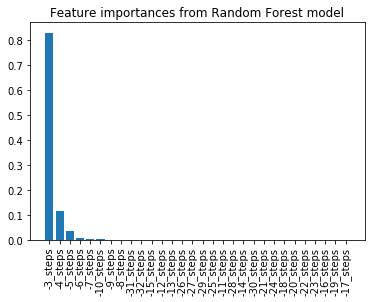

In [10]:
# Get feature importances from our random forest model
importances = rf.feature_importances_
importances = importances[importances != 0]

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.title("Feature importances from Random Forest model")
plt.show()

### Gradient Boosting Model

In [11]:
# Create GB model
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)
gradient_boosting_metrics = Metrics(y_test, gbr_pred)
gradient_boosting_metrics.report("Gradient Boosting")

# Look at the R^2 scores on train and test
print("R2 train: ", gbr.score(X_train, y_train))
print("R2 test: ", gbr.score(X_test, y_test))

# Election day result prediction 
test_gbr = y_test.tail(30).to_frame()
test_gbr_transposed = test_gbr.T
election_gbr = gbr.predict(test_gbr_transposed)
print("Election day prediction with Gradient Boosting: ", election_gbr)

#Compute RMSE of election day prediction
rmse_gbr = np.sqrt(mean_squared_error(actual_y, election_gbr))
print('RMSE Gradient Boosting: %.3f' % rmse_gbr)

Gradient Boosting results
~~~~~~~~~~~~~~~~~~~~~~~~~
RMSE: 0.278
MAE: 0.215
MALR: 0.022
R2 train:  0.9991004248293329
R2 test:  0.33194877929646827
Election day prediction with Gradient Boosting:  [8.80944642]
RMSE Gradient Boosting: 1.891


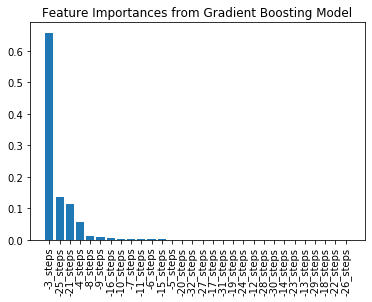

In [12]:
# Extract feature importances from the fitted gradient boosting model
feature_importances_gbr = gbr.feature_importances_
feature_importances_gbr = feature_importances_gbr[feature_importances_gbr != 0]

# Get the indices of the largest to smallest feature importances
sorted_index_gbr = np.argsort(feature_importances_gbr)[::-1]
x_gbr = range(features.shape[1])

# Create tick labels 
labels = np.array(feature_names)[sorted_index_gbr]

plt.bar(x_gbr, feature_importances_gbr[sorted_index_gbr], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.title('Feature Importances from Gradient Boosting Model')
plt.show()

### XGBoost Model

In [13]:
# Create the xgboost model and fit to the training data
xgb= XGBRegressor()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
XGBoost_metrics = Metrics(y_test, gbr_pred)
XGBoost_metrics.report("XGBoost")

# Look at the R^2 scores on train and test
print("R2 train: ", xgb.score(X_train, y_train))
print("R2 test: ", xgb.score(X_test, y_test))

# Election day result prediction 
test_xgb = y_test.tail(30).to_frame()
test_xgb_transposed = test_xgb.T

# Get feature names: 
test_xgb_transposed.columns = feature_names
election_xgb = xgb.predict(test_xgb_transposed)
print("Election day prediction with XGBoost: ", election_xgb)

#Compute RMSE of election day prediction
rmse_xgb = np.sqrt(mean_squared_error(actual_y, election_xgb))
print('RMSE XGBoost: %.3f' % rmse_xgb)

/Users/dangngochuy/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBoost results
~~~~~~~~~~~~~~~
RMSE: 0.278
MAE: 0.215
MALR: 0.022
R2 train:  0.9990522311235056
R2 test:  0.26893039271810004
Election day prediction with XGBoost:  [8.780952]
RMSE XGBoost: 1.919


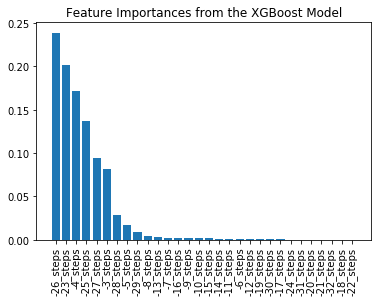

In [14]:
# Extract feature importances from the fitted gradient boosting model
feature_importances_xgb = xgb.feature_importances_
feature_importances_xgb = feature_importances_xgb[feature_importances_xgb != 0]

# Get the indices of the largest to smallest feature importances
sorted_index_xgb = np.argsort(feature_importances_xgb)[::-1]
x_xgb = range(features.shape[1])

# Create tick labels 
labels = np.array(feature_names)[sorted_index_xgb]

plt.bar(x_xgb, feature_importances_xgb[sorted_index_xgb], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.title('Feature Importances from the XGBoost Model')
plt.show()